In [1]:
using MAT
using NPZ
using Glob
using Dates
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Distributions
using DelimitedFiles

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14113143493739247815\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-337533783952709802\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14113143493739247815\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end;

#### Helper functions for rejection sampling

In [3]:
Norm(mu, sigma) = Distributions.Normal(mu, sigma);
Unif(a, b) = Distributions.Uniform(a, b);

function rejection_sample_mvn(num_samples, mu, sigma, current_samples, distance)
    
    i = 1
    rejectcount = 0
    distribution = MvNormal(vec(mu), vec(sigma))
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 2000)
        reset = false
        sample = rand(distribution, 1)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true; 
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            sample = transpose(sample)
            totalsample = vcat(totalsample, sample)
            i += 1
        end
    end
    
    if(rejectcount > 2000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end;

function rejection_sample_uniform(num_samples, a, b, current_samples, distance)
    
    i = 1
    rejectcount = 0
    totalsample = current_samples
    
    while(i <= num_samples && rejectcount <= 1000)
        reset = false
        sample = rand(Uniform(a,b), 1, 2)
        for j in eachrow(totalsample)
            dist = sqrt((j[1] - sample[1])^2 + (j[2] - sample[2])^2)
            if(dist <= distance)
                reset = true
                break
            end
        end
        if (reset)
            rejectcount += 1
        else
            totalsample = vcat(totalsample, sample)
            i += 1
        end

    end
    
    if(rejectcount > 1000)
        write(stderr, "WARNING: Exceeded threshold for max. rejections")
    end
    return totalsample
    
end

function rejection_sampling_1d(prob_dist::Function, param1, param2, num_samples, dist_thresh)
    
    cnt = 0
    
    samples = []
    
    num_tries = 0
    max_tries = 1e6
    
    while cnt < num_samples
        
        if num_tries >= max_tries
            print("ERROR: Exceeded max. tries after sampling " * string(cnt) * "/" * string(num_samples))
            return nothing
        end
        
        new_sample = rand(prob_dist(param1, param2), 1)[1]
        
        if length(samples) > 0
            if sum(abs.(new_sample .- samples) .< dist_thresh) == 0
                push!(samples, new_sample)
                cnt += 1
            end
        else
            push!(samples, new_sample)
            cnt += 1
        end
        
        num_tries += 1
        
    end
    
    return samples
    
end;

#### Plotting

In [4]:
function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "dimgray")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "gold")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], 6, color = "blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

#### Simulate Zebrafish skin pigmentation configurations

In [5]:
function generate_stripes(num_stripes, tot_num_cells, stripe_num_cells, stripe_width_mu, stripe_width_var, 
                          stripe_cell_type, seed)
    
    Random.seed!(seed)
    
    o_type = 1
    if stripe_cell_type == 1
       o_type = 2 
    end
    
    stripe_pop = floor(Int, stripe_num_cells/num_stripes)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(stripe_num_cells) * stripe_cell_type
    stripepos = Array{Float64}(undef, num_stripes, stripe_pop, 2)
    for i in 1:num_stripes
        
        stripe_center = -10 - 2.5 + (i * 20/num_stripes)
        stripe_width = rand(Normal(stripe_width_mu, stripe_width_var), 1)[1]
        
        # Sample without rejection:
        stripe_x = rand(Uniform(-10, 10), stripe_pop)
        stripe_y = rand(Uniform(stripe_center-stripe_width, stripe_center+stripe_width), stripe_pop)
        
        # Sample with rejection:
        # stripe_x = rejection_sampling_1d(Unif, -10, 10, stripe_pop, 1e-3)
        # stripe_y = rejection_sampling_1d(Unif, stripe_center-stripe_width, stripe_center+stripe_width, 
        #    stripe_pop, 1e-3)
        
        cellpos = vcat(cellpos, hcat(stripe_x, stripe_y))
        stripepos[i,:,1] = stripe_x
        stripepos[i,:,2] = stripe_y
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - stripe_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - stripe_num_cells, 1))
    
    return (cellpos, celltypes,stripepos)
    
end

function generate_sinusoidal_stripes(num_stripes, tot_num_cells, stripe_num_cells, stripe_width_var, amplitude,
                                     stripe_phase_var, sin_freq, stripe_cell_type, seed)
    
    Random.seed!(seed)
    
    o_type = 1
    if stripe_cell_type == 1
       o_type = 2 
    end
    
    stripe_pop = floor(Int, stripe_num_cells/num_stripes)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(stripe_num_cells) * stripe_cell_type
    
    stripepos = Array{Float64}(undef, num_stripes, stripe_pop, 2)
    
    for i in 1:num_stripes
        
        stripe_center = -10 - 3 + (i * 20/num_stripes)
        
        # Sample without rejection:
        stripe_x = rand(Uniform(-10, 10), stripe_pop)
        stripe_y_noise = rand(Normal(0, stripe_width_var), stripe_pop)
        
        # Sample with rejection:
        # stripe_x = rejection_sampling_1d(Unif, -10, 10, stripe_pop, 1e-2)
        # stripe_y_noise = rejection_sampling_1d(Norm, stripe_width_mu, stripe_width_var, stripe_pop, 1e-2)
        
        phase_shift = rand(Normal(0, stripe_phase_var), 1)

        stripe_y = stripe_center*ones(stripe_pop) + stripe_y_noise + amplitude.*sin.(sin_freq.*stripe_x .+ phase_shift)
        
        cellpos = vcat(cellpos, hcat(stripe_x, stripe_y))
        
        stripepos[i,:,1] = stripe_x
        stripepos[i,:,2] = stripe_y
        
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - stripe_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - stripe_num_cells, 1))
    
    return (cellpos, celltypes, stripepos)
    
end

function generate_spots(num_spots, tot_num_cells, spot_num_cells, spot_width_mu, spot_width_var, 
                        spot_cell_type, seed)
    
    Random.seed!(seed)
    
    o_type = 1
    if spot_cell_type == 1
       o_type = 2 
    end
    
    spot_pop = floor(Int, spot_num_cells/num_spots)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(spot_num_cells) * spot_cell_type
    
    for i in 1:num_spots
        clustercenter = rand(Uniform(-9, 9), 1, 2)
        sigma = rand(Normal(spot_width_mu, spot_width_var), 1, 2)
        cellpos = rejection_sample_mvn(spot_pop, clustercenter, sigma, cellpos, 0.05)
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - spot_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - spot_num_cells, 1))
    
    #npzwrite("cellpositions.npz", cellpos)
    #npzwrite("celltypes.npz", celltypes)
    
    return (cellpos, celltypes)

end

function generate_fixed_spots(num_spots, tot_num_cells, spot_num_cells, spot_width_mu, spot_width_var, 
                              spot_cell_type, position_seed, param_seed)
    
    o_type = 1
    if spot_cell_type == 1
       o_type = 2 
    end
    
    spot_pop = floor(Int, spot_num_cells/num_spots)
    
    cellpos = Array{Float64}(undef, 0, 2)
    celltypes = ones(spot_num_cells) * spot_cell_type
    
    Random.seed!(position_seed)
    
    clustercenter = Array{Float64}(undef, num_spots, 2)
    
    for i in 1:num_spots
        clustercenter[i,:] = rand(Uniform(-9, 9), 1, 2)
    end
    
    Random.seed!(param_seed)
    
    for i in 1:num_spots
        sigma = rand(Normal(spot_width_mu, spot_width_var), 1, 2)
        cellpos = rejection_sample_mvn(spot_pop, clustercenter[i,:], sigma, cellpos, 0.05)
    end
    
    cellpos = rejection_sample_uniform(tot_num_cells - spot_num_cells, -10, 10, cellpos, 0.3)
    
    celltypes = vcat(celltypes, o_type*ones(tot_num_cells - spot_num_cells, 1))
    
    return (cellpos, celltypes)

end;

#### Helper methods to calculate stripe statistics

In [6]:
function pairwise_euclidean(X)
    
    num_samples = size(X)[1]
    num_feats = size(X)[2]
    
    D = Array{Float64}(undef, num_samples, num_samples)
    
    for i in range(1, stop=num_samples)
        
        j = 1
        while (j < i)
            
            d = 0.0
            for k in range(1, stop=num_feats)
                d += (X[i,k] - X[j,k])^2
            end
            
            D[i,j] = sqrt(d) 
            D[j,i] = D[i,j]
            j += 1
            
        end
        
        D[i,i] = 0.0
        
    end
    
    return D
    
end;
    
function interparticle_dist(stripe_data)
    
    avg_cell_distance = 0.0

    num_cells = 0
    for s in range(1, stop=size(stripe_data)[1])

        D = pairwise_euclidean(stripe_data[s,:,:])

        avg_cell_distance += sum(sort(D, dims=2)[:,2])
        num_cells += size(D)[1]

    end

    avg_cell_distance /= num_cells
    
    return avg_cell_distance
    
end;

function interstripe_dist(stripe_data)
    
    avg_stripe_distance = 0.0
    num_cells = 0

    for s1 in range(1, stop=size(stripe_data)[1])
        for cid in range(1, stop=size(stripe_data)[2])

            cell_pos = stripe_data[s1, cid, :]

            all_distances = Array{Float64}(undef, (size(stripe_data)[1]-1)*size(stripe_data)[2])
            cnt = 0

            for s2 in range(1, stop=size(stripe_data)[1])

                if s2 != s1

                    for cid2 in range(1, stop=size(stripe_data)[2])

                        cell2_pos = stripe_data[s2, cid2, :]
                        d = 0.0
                        for k in range(1, stop=size(stripe_data)[3])
                            d += (cell_pos[k] - cell2_pos[k])^2
                        end

                        cnt += 1
                        all_distances[cnt] = sqrt(d)

                    end

                end

            end

            avg_stripe_distance += minimum(all_distances)
            num_cells += 1

        end

    end

    avg_stripe_distance /= num_cells
    
    return avg_stripe_distance
    
end;

# reimplemented by WZ to support random deletion and scaling
function interparticle_dist2(stripe_data)
    
    avg_cell_distance = 0.0

    num_cells = 0
    for s in range(1, stop=size(stripe_data)[1])

        D = pairwise_euclidean(stripe_data[s])
        if(size(D)[2] <= 2)
            return 0
        end
        avg_cell_distance += sum(sort(D, dims=2)[:,2])
        num_cells += size(D)[1]

    end

    avg_cell_distance /= num_cells
    
    return avg_cell_distance
    
end;

# reimplemented by WZ to support random deletion and scaling
function interstripe_dist2(stripe_data)
    
    avg_stripe_distance = 0.0
    num_cells = 0
    for s1 in range(1, stop=size(stripe_data)[1])
        for cellstripe in range(1,stop = size(stripe_data[s1])[1])
            cell_pos = stripe_data[s1][cellstripe, :]
            alldist = []
            for s2 in range(1, stop=size(stripe_data)[1])
                if s2!=s1
                    for cellstripe2 in range(1, stop = size(stripe_data[s2])[1])
                        cell_pos2 = stripe_data[s2][cellstripe2, :]
                        d = 0.0
                        for j in range(1, stop= size(cell_pos)[1])
                            d += (cell_pos[j] - cell_pos2[j])^2
                        end
                        push!(alldist, sqrt(d))
                    end
                end
            end
            avg_stripe_distance += minimum(alldist)
            num_cells += 1
        end
    end
    avg_stripe_distance /= num_cells
    
    return avg_stripe_distance
    
end;

#### Sinusoidal stripe pattern

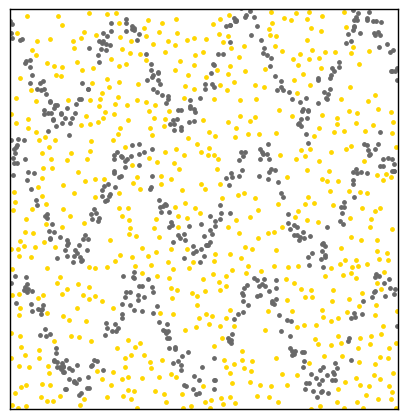

In [7]:
# num of stripes = 2, 4[*], 5
# total number of cells: 1200
# number of cells in stripes: 500
# stripe width (sigma) = 0.2, 0.4[*], 0.6
# phase variance = 0.01[*], 0.5, 2.5
# stripe frequency = 0.01, 0.5[*], 1.5, 2.0, 3.5

num_stripes = 3
num_particles = 1200
num_red_particles = 600

stripe_width_var = 0.5            # [0.1, 0.4, 0.7, 1.0]

sin_amp = 2.5                     # [0.5, 1.0, 2.0, 3.0]
sin_phase_var = 5.0
sin_omega = 1.0                   # [0.1, 1.0, 2.0, 4.0]
sin_freq = sin_omega/(2*π)

rand_seed = Int(floor(datetime2unix(now())))

(cell_pos, cell_types, stripe_data) = generate_sinusoidal_stripes(num_stripes, num_particles, num_red_particles, 
                                                        stripe_width_var, sin_amp, sin_phase_var, sin_omega,
                                                        1, rand_seed)   
plot_syn_data(cell_pos, cell_types);

In [8]:
filename = "wstripes_" * string(rand_seed) * ".npz"
print("Writing file: " * filename)

file_dict = Dict("pos" => cell_pos, "types" => cell_types, "random_seed" => rand_seed,
                 "num_stripes" => num_stripes, "num_particles" => num_particles, 
                "num_stripe_particles" => num_red_particles, "stripe_width_var" => stripe_width_var,
                "sin_amp" => sin_amp, "sin_phase_var" => sin_phase_var, "sin_omega" => sin_omega,
                "interparticle_dist_avg" => interparticle_dist(stripe_data), 
                "interstripe_dist_avg" => interstripe_dist(stripe_data))

Writing file: wstripes_1635980340.npz

Dict{String,Any} with 12 entries:
  "types"                  => [1.0; 1.0; … ; 2.0; 2.0]
  "sin_amp"                => 2.5
  "interstripe_dist_avg"   => 3.66759
  "sin_phase_var"          => 5.0
  "stripe_width_var"       => 0.5
  "num_stripes"            => 3
  "interparticle_dist_avg" => 0.235662
  "num_stripe_particles"   => 600
  "pos"                    => [-5.20502 -8.03948; -3.79108 -4.16591; … ; -7.345…
  "sin_omega"              => 1.0
  "random_seed"            => 1635980340
  "num_particles"          => 1200

#### Random particle removal

In [9]:
frac_removals = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05];

In [10]:
bash""" 
rm -rf stripe_deletions
mkdir stripe_deletions
"""

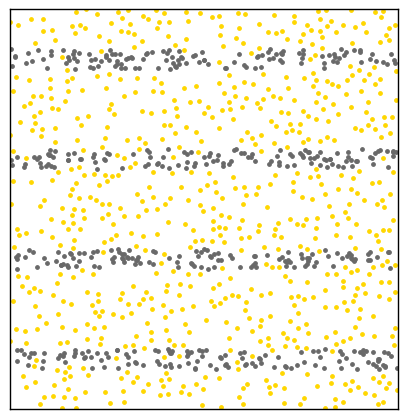

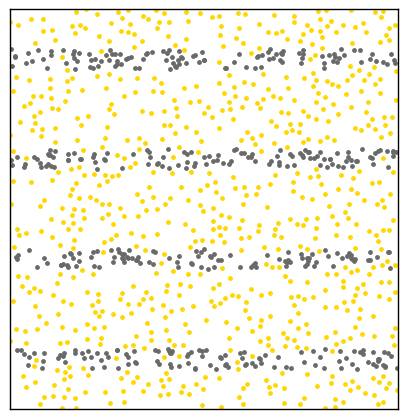

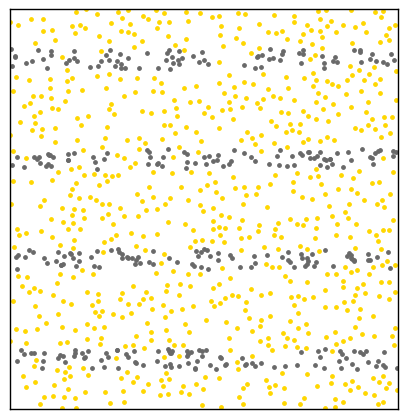

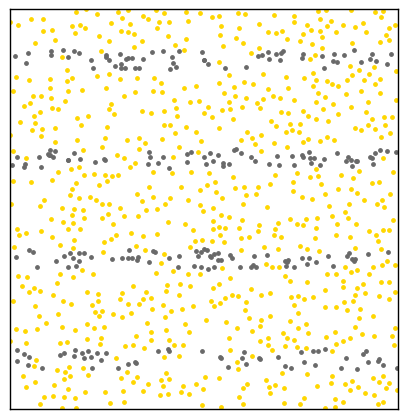

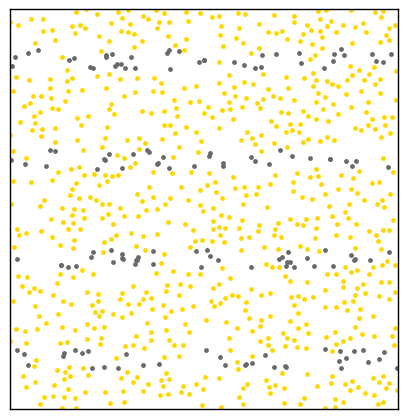

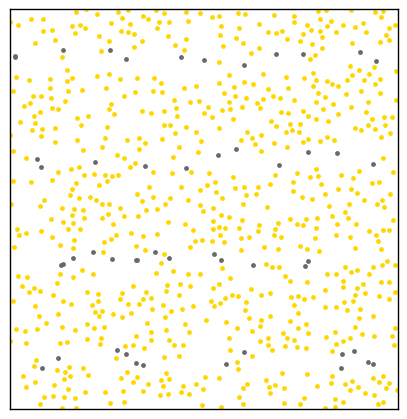

In [11]:
num_reps = 5

parent_folder = "stripe_deletions"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)

    rand_seed = Int(floor(datetime2unix(now())))
    
    num_stripes = 4
    num_cells_tot = 1200
    num_t1_cells = 500
    stripe_width_mu = 0.5
    stripe_width_var = 0.01
    
    (cell_pos, cell_types, stripedata) = generate_stripes(num_stripes, num_cells_tot, num_t1_cells, 
                                                            stripe_width_mu, stripe_width_var, 1, rand_seed)
    
    if rep == 1
        plot_syn_data(cell_pos, cell_types);
    end

    for itr in range(1, stop=length(frac_removals))

        num_removals = Int(frac_removals[itr]*num_t1_cells)

        rm_idx = randperm(num_t1_cells)[1:num_t1_cells-num_removals]

        cellpos_new = Array{Float64}(undef, 0, 2)
        stripes = []
        for eachstripe in range(1, stop = size(stripedata)[1])
            push!(stripes, Array{Float64}(undef,0, size(stripedata)[3]))
        end
        cell_types_new = Array{Float64}(undef, 0, 1)

        t1_cnt = 0
        new_cnt = 0
        new_t1_cnt = 0
        for cid in range(1, stop=num_cells_tot)
            if cell_types[cid] == 1
                t1_cnt += 1
                if ~(t1_cnt in rm_idx)
                    cellpos_new = vcat(cellpos_new, transpose(cell_pos[cid,:]))
                    cell_types_new = vcat(cell_types_new, cell_types[cid])
                    location = indexin(cell_pos[cid,:], stripedata )[1][1]
                    cell_pos_alt = transpose(cell_pos[cid,:])
                    stripes[location] = [stripes[location];cell_pos_alt]
                    new_cnt += 1
                    new_t1_cnt += 1
                end
            else
                # keep type 2 cells
                cellpos_new = vcat(cellpos_new, transpose(cell_pos[cid,:]))
                cell_types_new = vcat(cell_types_new, cell_types[cid])
                new_cnt += 1
            end

        end

        if rep == 1
            if itr % 2 == 0
                plot_syn_data(cellpos_new, cell_types_new);
            end
        end
        
        rand_seed_new = string(rand_seed) * "_" * string(itr)
        
        filename = storage_folder * "/wstripes_" * string(rand_seed_new) * ".npz"

        file_dict = Dict("pos" => cellpos_new, "types" => cell_types_new, "random_seed" => rand_seed,
                    "removal_fraction" => frac_removals[itr],
                    "num_stripes" => num_stripes, "num_particles" => new_cnt, "num_stripe_particles" => new_t1_cnt, 
                    "stripe_width_mu" => stripe_width_mu, "stripe_width_var" => stripe_width_var,
                    "sin_amp" => 0, "sin_phase_var" => 0, "sin_omega" => 0,
                    "interparticle_dist_avg" => interparticle_dist2(stripes),
                    "interstripe_dist_avg" => interstripe_dist2(stripes))

        npzwrite(filename, file_dict)

        sleep(1)
        
    end
    
end

#### Scaling

In [12]:
scales = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2];

In [13]:
bash""" 
rm -rf stripe_scaling
mkdir stripe_scaling
"""

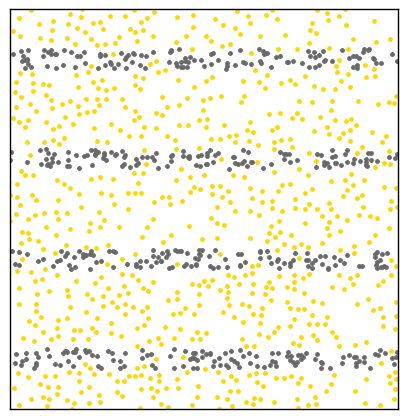

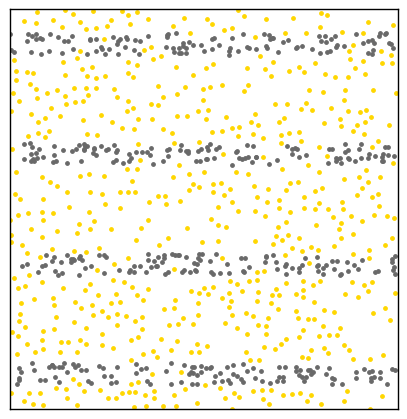

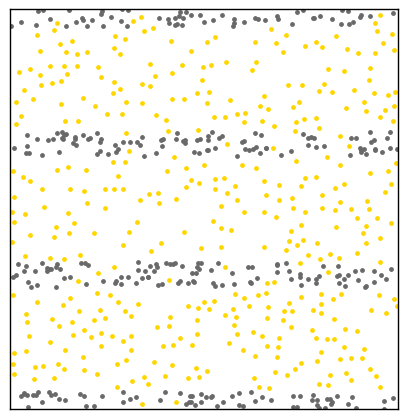

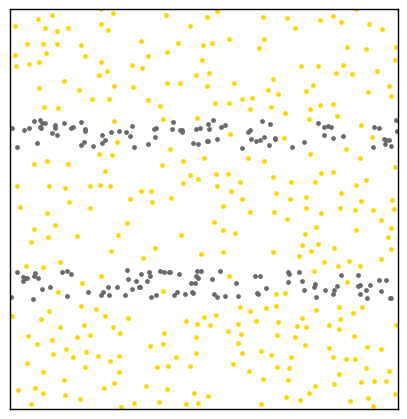

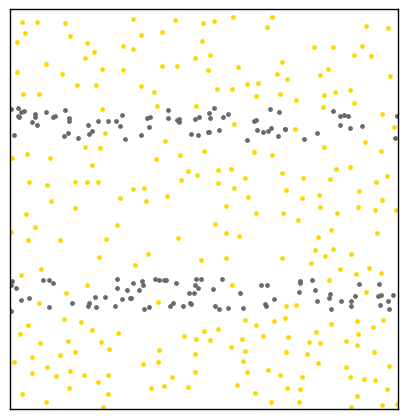

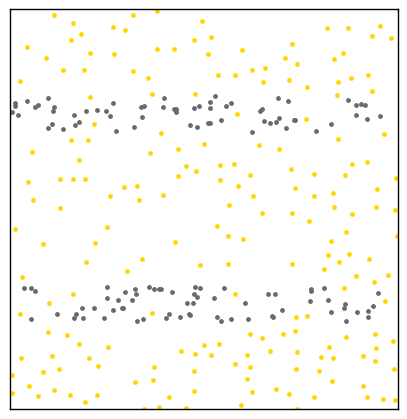

In [14]:
num_reps = 5

parent_folder = "stripe_scaling"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)
    
    rand_seed = Int(floor(datetime2unix(now())))
    
    num_stripes = 4
    N_cells = 1200
    num_stripe_cells = 500
    stripe_width_mu = 0.5
    stripe_width_var = 0.01

    (cell_pos, cell_types, stripedata) = generate_stripes(num_stripes, N_cells, num_stripe_cells, 
                                                          stripe_width_mu, stripe_width_var, 1, rand_seed)
    
    stripe_cells = size(stripedata)[2]
    
    if rep == 1
        plot_syn_data(cell_pos, cell_types);
    end
    
    for itr in range(1, stop=length(scales))

        stripes = []

        sc = scales[itr]
        scaled_pos = cell_pos .* sc    
        oob_mask = .|(abs.(scaled_pos[:,1]) .> 10, abs.(scaled_pos[:,2]) .> 10)

        xpos = [scaled_pos[i,1] for i in range(1, stop=N_cells) if oob_mask[i]==0]
        ypos = [scaled_pos[i,2] for i in range(1, stop=N_cells) if oob_mask[i]==0]

        scaled_stripe_pos = stripedata .* sc
        oob_stripe = .|(abs.(scaled_stripe_pos[:,:,1]) .> 10, abs.(scaled_stripe_pos[:,:,2]) .> 10)

        for j in range(1,stop = size(stripedata)[1])
            stripexpos = [scaled_stripe_pos[j,i,1] for i in range(1, stop=stripe_cells) if oob_stripe[i]==0]
            stripeypos = [scaled_stripe_pos[j,i,2] for i in range(1, stop=stripe_cells) if oob_stripe[i]==0]
            stripepos_new = hcat(stripexpos,stripeypos)
            push!(stripes, stripepos_new)
        end

        cellpos_new = hcat(xpos, ypos)
        cell_types_new = [cell_types[i] for i in range(1, stop=N_cells) if oob_mask[i]==0]
                                                                                                                   
        if rep == 1
            if itr % 2 == 0
                plot_syn_data(cellpos_new, cell_types_new);
            end
        end
        
        rand_seed_new = string(rand_seed) * "_" * string(itr)
        
        filename = storage_folder * "/wstripes_" * string(rand_seed_new) * ".npz"

        file_dict = Dict("pos" => cellpos_new, "types" => cell_types_new, "random_seed" => rand_seed,
                    "scale" => scales[itr],
                    "num_stripes" => num_stripes, "num_particles" => size(cellpos_new)[1], 
                    "num_stripe_particles" => sum(cell_types_new.==1), 
                    "stripe_width_mu" => stripe_width_mu, "stripe_width_var" => stripe_width_var,
                    "sin_amp" => 0, "sin_phase_var" => 0, "sin_omega" => 0,
                    "interparticle_dist_avg" => interparticle_dist2(stripes),
                    "interstripe_dist_avg" => interstripe_dist2(stripes))

        npzwrite(filename, file_dict)

        sleep(1)
                                                                                                                        
    end
                                                                
end

#### Cropping (Vertical)

In [15]:
crops = [1.0, 0.95, 0.85, 0.75, 0.65, 0.55, 0.45, 0.35, 0.25, 0.15, 0.05];

In [16]:
bash""" 
rm -rf vert_crop
mkdir vert_crop
"""

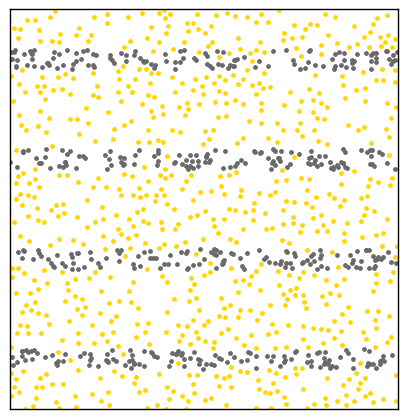

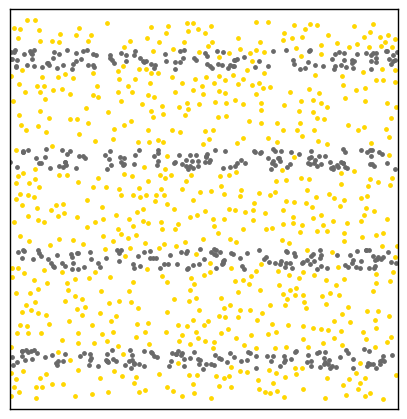

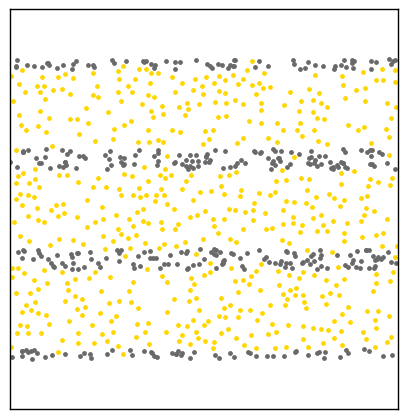

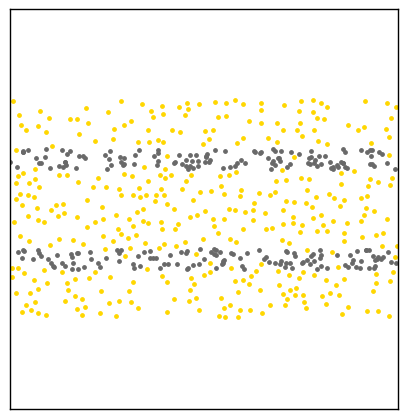

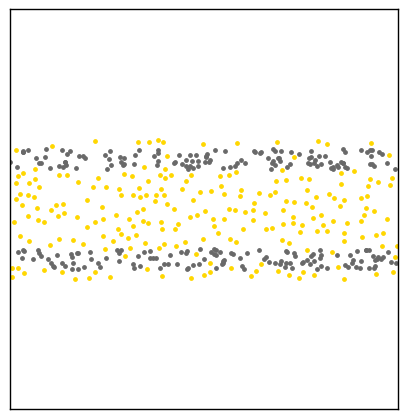

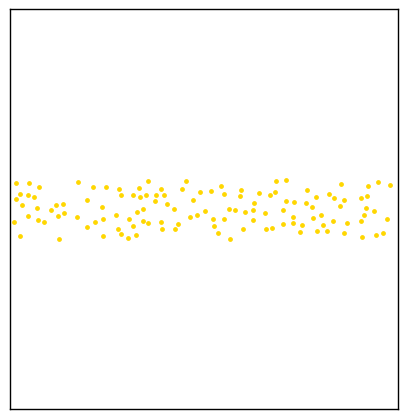

In [17]:
num_reps = 5

parent_folder = "vert_crop"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)
    
    rand_seed = Int(floor(datetime2unix(now())))
    
    num_stripes = 4
    N_cells = 1200
    num_stripe_cells = 500
    stripe_width_mu = 0.5
    stripe_width_var = 0.01

    (cell_pos, cell_types, stripedata) = generate_stripes(num_stripes, N_cells, num_stripe_cells, 
                                                          stripe_width_mu, stripe_width_var, 1, rand_seed)
    
    stripe_cells = size(stripedata)[2]
    
    if rep == 1
        plot_syn_data(cell_pos, cell_types);
    end
    
    for itr in range(1, stop=length(crops))

        stripes = []
        
        view_frac = crops[itr]
        cutoff = view_frac * 10
         
        oob_mask = .|(abs.(cell_pos[:,1]) .> 10, abs.(cell_pos[:,2]) .> cutoff)

        xpos = [cell_pos[i,1] for i in range(1, stop=N_cells) if oob_mask[i]==0]
        ypos = [cell_pos[i,2] for i in range(1, stop=N_cells) if oob_mask[i]==0]

        oob_stripe = .|(abs.(stripedata[:,:,1]) .> 10, abs.(stripedata[:,:,2]) .> cutoff)

        for j in range(1,stop = size(stripedata)[1])
            stripexpos = [stripedata[j,i,1] for i in range(1, stop=stripe_cells) if oob_stripe[i]==0]
            stripeypos = [stripedata[j,i,2] for i in range(1, stop=stripe_cells) if oob_stripe[i]==0]
            stripepos_new = hcat(stripexpos, stripeypos)
            push!(stripes, stripepos_new)
        end

        cellpos_new = hcat(xpos, ypos)
        cell_types_new = [cell_types[i] for i in range(1, stop=N_cells) if oob_mask[i]==0]
                                                                                                                   
        if rep == 1
            if itr % 2 == 0
                plot_syn_data(cellpos_new, cell_types_new);
            end
        end
        
        rand_seed_new = string(rand_seed) * "_" * string(itr)
        
        filename = storage_folder * "/wstripes_" * string(rand_seed_new) * ".npz"
        
        istripe_dist = interstripe_dist2(stripes)
        if isnothing(istripe_dist) || isnan(istripe_dist)
            istripe_dist = 0
        end

        file_dict = Dict("pos" => cellpos_new, "types" => cell_types_new, "random_seed" => rand_seed,
                    "crop_fraction" => crops[itr],
                    "num_stripes" => num_stripes, "num_particles" => size(cellpos_new)[1], 
                    "num_stripe_particles" => sum(cell_types_new.==1), 
                    "stripe_width_mu" => stripe_width_mu, "stripe_width_var" => stripe_width_var,
                    "sin_amp" => 0, "sin_phase_var" => 0, "sin_omega" => 0,
                    "interparticle_dist_avg" => interparticle_dist2(stripes),
                    "interstripe_dist_avg" => istripe_dist)

        npzwrite(filename, file_dict)

        sleep(1)
                                                                                                                        
    end
                                                                
end

#### Cropping (Horizontal)

In [18]:
crops = [1.0, 0.95, 0.85, 0.75, 0.65, 0.55, 0.45, 0.35, 0.25, 0.15, 0.05];

In [19]:
bash""" 
rm -rf h_crop
mkdir h_crop
"""

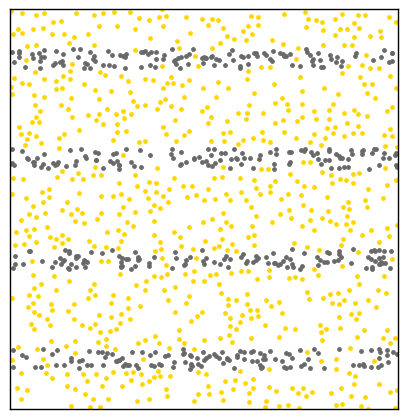

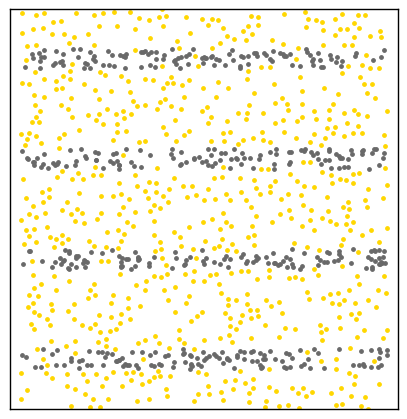

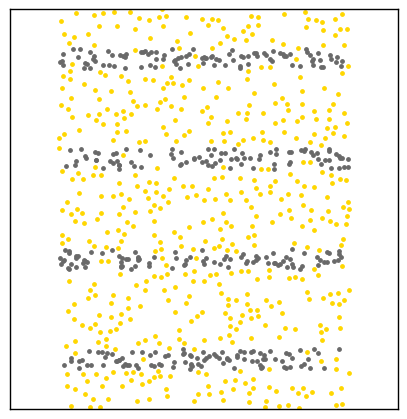

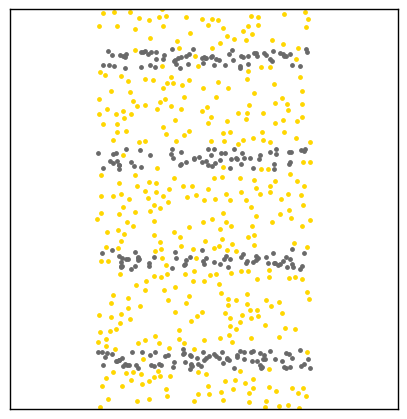

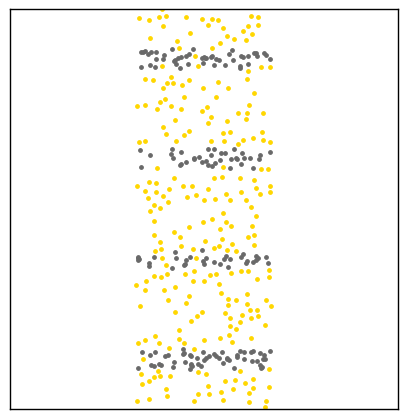

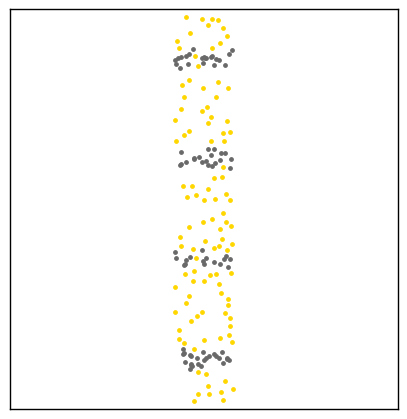

In [20]:
num_reps = 5

parent_folder = "h_crop"

for rep in 1:num_reps
    
    storage_folder = parent_folder * "/" * string(rep)
    
    mkdir(storage_folder)
    
    rand_seed = Int(floor(datetime2unix(now())))
    
    num_stripes = 4
    N_cells = 1200
    num_stripe_cells = 500
    stripe_width_mu = 0.5
    stripe_width_var = 0.01

    (cell_pos, cell_types, stripedata) = generate_stripes(num_stripes, N_cells, num_stripe_cells, 
                                                          stripe_width_mu, stripe_width_var, 1, rand_seed)
    
    stripe_cells = size(stripedata)[2]
    
    if rep == 1
        plot_syn_data(cell_pos, cell_types);
    end
    
    for itr in range(1, stop=length(crops))

        stripes = []
        
        view_frac = crops[itr]
        cutoff = view_frac * 10
         
        oob_mask = .|(abs.(cell_pos[:,1]) .> cutoff, abs.(cell_pos[:,2]) .> 10)

        xpos = [cell_pos[i,1] for i in range(1, stop=N_cells) if oob_mask[i]==0]
        ypos = [cell_pos[i,2] for i in range(1, stop=N_cells) if oob_mask[i]==0]

        oob_stripe = .|(abs.(stripedata[:,:,1]) .> cutoff, abs.(stripedata[:,:,2]) .> 10)

        for j in range(1,stop = size(stripedata)[1])
            stripexpos = [stripedata[j,i,1] for i in range(1, stop=stripe_cells) if oob_stripe[i]==0]
            stripeypos = [stripedata[j,i,2] for i in range(1, stop=stripe_cells) if oob_stripe[i]==0]
            stripepos_new = hcat(stripexpos, stripeypos)
            push!(stripes, stripepos_new)
        end

        cellpos_new = hcat(xpos, ypos)
        cell_types_new = [cell_types[i] for i in range(1, stop=N_cells) if oob_mask[i]==0]
                                                                                                                   
        if rep == 1
            if itr % 2 == 0
                plot_syn_data(cellpos_new, cell_types_new);
            end
        end
        
        rand_seed_new = string(rand_seed) * "_" * string(itr)
        
        filename = storage_folder * "/wstripes_" * string(rand_seed_new) * ".npz"

        file_dict = Dict("pos" => cellpos_new, "types" => cell_types_new, "random_seed" => rand_seed,
                    "crop_fraction" => crops[itr],
                    "num_stripes" => num_stripes, "num_particles" => size(cellpos_new)[1], 
                    "num_stripe_particles" => sum(cell_types_new.==1), 
                    "stripe_width_mu" => stripe_width_mu, "stripe_width_var" => stripe_width_var,
                    "sin_amp" => 0, "sin_phase_var" => 0, "sin_omega" => 0,
                    "interparticle_dist_avg" => interparticle_dist2(stripes),
                    "interstripe_dist_avg" => interstripe_dist2(stripes))

        npzwrite(filename, file_dict)

        sleep(1)
                                                                                                                        
    end
                                                                
end